In [1]:
from pathlib import Path
import os
import numpy as np
from matplotlib import pyplot as plt
import tkinter as tk
from tkinter import filedialog
import scipy.io


from src.eeg_analysis.preprocessing.eeg_file import EEGFile
from src.eeg_analysis.preprocessing.eeg_preprocessor import EEGPreprocessor
from src.eeg_analysis.analysis.phase_lag_index import PhaseLagIndex
from src.eeg_analysis.visualization.my_custom_style import set_custom_style
from src.eeg_analysis.utils.helpers import bottom_left_off_diagonal

In [2]:
# participant_id = 3
# base_dir = Path(r'D:\Anesthesia_Research_Fellow') / f'CA-{participant_id:02}'
# base_path = base_dir / f'CA-{participant_id:02}'

# # Make a directory for analysis results
# base_results_dir = base_dir / 'analysis_results'
# if not base_results_dir.exists():
#     base_results_dir.mkdir(parents=True, exist_ok=True)

# vhdr_path = base_path.with_suffix('.vhdr')
# vmrk_path = base_path.with_suffix('.vmrk')
# eeg_path = base_path.with_suffix('.eeg')

# eeg_file = EEGFile(participant_id, str(vhdr_path), str(vmrk_path), str(eeg_path))
# eeg_file.load_data()

In [3]:
dataset_dir = 'E:/Caffeine_data'
participant_name = 'CA-52'

In [4]:
def get_eeg_file(dataset_dir=None, participant_name=None):

    if (dataset_dir is not None) & (participant_name is not None):
        eeg_path = Path(f'{dataset_dir}/{participant_name}/{participant_name}').with_suffix('.eeg')
    else: 
        # Create a Tkinter root window (it will not be shown)
        root = tk.Tk()
        root.withdraw()
        
        # Set the file dialog to appear in front
        root.attributes('-topmost', True)

        # Ask the user to select a .eeg file
        eeg_file_path = filedialog.askopenfilename(title="Select EEG File", filetypes=[("EEG files", "*.eeg")])
        if not eeg_file_path:
            raise FileNotFoundError("No file selected.")
        
        # Convert to Path object for easier manipulation
        eeg_path = Path(eeg_file_path)
    
    base_path = eeg_path.with_suffix('')
    base_dir = eeg_path.parent
    
    # Extract participant ID (assuming filename is `CA-XX.eeg`)
    participant_name = base_path.name
    participant_id = int(participant_name.split('-')[1])  # Adjust this if your file naming convention is different
    
    # Generate paths for the corresponding files
    vhdr_path = base_path.with_suffix('.vhdr')
    vmrk_path = base_path.with_suffix('.vmrk')

    return participant_id, base_dir, vhdr_path, vmrk_path, eeg_path

participant_id, base_dir, vhdr_path, vmrk_path, eeg_path = get_eeg_file(dataset_dir, participant_name)

# Make a directory for analysis results
base_results_dir = base_dir / 'analysis_results'
if not base_results_dir.exists():
    base_results_dir.mkdir(parents=True, exist_ok=True)

eeg_file = EEGFile(participant_id, str(vhdr_path), str(vmrk_path), str(eeg_path))
eeg_file.read_vhdr()

#### Preprocessing
We can either import Duan's preprocessed EEG data or handle the preprocessing ourselves.

##### Handling preprocessing ourselves

In [5]:
# preprocessor = EEGPreprocessor(eeg_file)

# target_fs = 250
# window_size = 10
# step_size = 5
# order = 5
# low_cutoff = 0.5
# high_cutoff = 55
# epoch_length = 30

# sequence_of_operations = [
#     ('downsample', {'target_fs': target_fs}),
#     ('create_epochs', {'events_df': eeg_file.events_df}),
#     # ('detrend', {'window_size': window_size, 'step_size': step_size}),
#     # ('re_reference', {'reference_type': 'average'}),
#     ('bandpass_filter', {'order': order,'low_cutoff': low_cutoff, 'high_cutoff': high_cutoff}),
#     ('exclude_noisy_periods', {'window_size':2, 'threshold':10, 'min_num_channels':1, 'padding':'zeros'})
# ]
# preprocessor.process(sequence_of_operations)

#### Importing Duan's preprocessed EEG

In [6]:
def load_mat_file(participant_id, epoch, variables, all_channel_names):

    base_dir = Path(r'D:/Anesthesia_Research_Fellow/preprocessed_EEG_by_DuanLI')
    base_filename = f'CA_{participant_id:02}_{epoch}_denoised.mat'
    file_path = base_dir / base_filename

    # Check if the file exists
    if not file_path.exists():
        raise FileNotFoundError(f"The file {file_path} does not exist")

    # Load .mat file
    mat_data = scipy.io.loadmat(file_path)

    # Access the variables
    data={}
    for variable in variables:
        if variable in mat_data:
            curr_variable = mat_data[variable]
            if variable in ['zz_epoch', 'zz_noise']:
                data[variable] = np.transpose(curr_variable, [1, 0])
            elif variable in ['channels_remained', 'Index_tt']:
                data[variable] = curr_variable.flatten() - 1 # Due to Python zero-indexing
            elif variable in ['fs', 'L_raw', 'L_denoised']:
                data[variable] = curr_variable.flatten()[0]
            else:
                data[variable] = curr_variable.flatten()
        else:
            print(f"The variable '{variable}' does not exist in the .mat file for epoch '{epoch}'")
    
    # channels_remained = data['channels_remained'].flatten().tolist()
    # data['channel_names'] = [all_channel_names[i] for i in channels_remained]
    # data['omitted_channel_names'] = [item for item in all_channel_names if (item not in data['channel_names']) & (len(item) <= 3)]

    return data

# Example for loading different epochs for participant_id = 1
epoch_names = ['preOP_epoch', 'preExtube', 'PACU_epoch']
new_epoch_names = {
    'preOP_epoch': 'preop_rest',
    'preExtube': 'emergence',
    'PACU_epoch': 'pacu_rest'
}
variables = ['channels_remained', 'fs', 'L_denoised', 'L_raw', 'tt', 'Index_tt', 'zz_epoch', 'zz_noise']
all_channel_names = eeg_file.channel_names

epoch_data = {}
for epoch_name in epoch_names:
    try:
        epoch_data[new_epoch_names[epoch_name]] = load_mat_file(participant_id, epoch_name, variables, all_channel_names)
        
        # Process the loaded data as needed
    except FileNotFoundError as e:
        print(e)

The variable 'L_denoised' does not exist in the .mat file for epoch 'preOP_epoch'
The variable 'L_raw' does not exist in the .mat file for epoch 'preOP_epoch'
The variable 'Index_tt' does not exist in the .mat file for epoch 'preExtube'
The variable 'L_denoised' does not exist in the .mat file for epoch 'PACU_epoch'
The variable 'L_raw' does not exist in the .mat file for epoch 'PACU_epoch'


#### Zero padding the eeg data, so the time dimension is linear (with no missing point)

In [7]:
total_num_eeg_channels = 16

epoch_names = list(epoch_data.keys())
for epoch_name in epoch_names:
    if epoch_name == 'emergence':
        curr_epoch_data = epoch_data[epoch_name]
        tt = curr_epoch_data['tt']
        min_tt = np.min(tt)
        max_tt = np.max(tt)
        
        complete_time_range = np.arange(min_tt, max_tt + 1)
        time_indices = tt - min_tt  # These are the positions where `tt` values should go

        # Preallocate zero-padded EEG data arrays
        for eeg_data_name in ['zz_epoch', 'zz_noise']:
            curr_eeg_data = curr_epoch_data[eeg_data_name]
            zero_padded_eeg = np.zeros((len(complete_time_range), curr_eeg_data.shape[1]))

            # Utilize NumPy indexing to fill in the non-zero data
            zero_padded_eeg[time_indices] = curr_eeg_data

            epoch_data[epoch_name][eeg_data_name] = zero_padded_eeg

        epoch_data[epoch_name]['tt'] = complete_time_range

    else:
        epoch_data[epoch_name]['tt'] = epoch_data[epoch_name]['Index_tt']
        del epoch_data[epoch_name]['Index_tt']


    curr_epoch_data = epoch_data[epoch_name]
    curr_channels_remained = curr_epoch_data['channels_remained']
    for eeg_data_name in ['zz_epoch']: #, 'zz_noise'
        zero_padded_channels = np.zeros((curr_epoch_data['zz_epoch'].shape[0], total_num_eeg_channels))

        for i_chan, chan in enumerate(curr_channels_remained):
            zero_padded_channels[:, chan] = curr_epoch_data[eeg_data_name][:, i_chan]

        epoch_data[epoch_name][eeg_data_name] = zero_padded_channels

    epoch_data[epoch_name]['eliminated_channels'] = [i for i in range(total_num_eeg_channels) if i not in curr_channels_remained.tolist()]
    del epoch_data[epoch_name]['channels_remained']

#### Generate .eeg file from the imported data for visualizing the eeg using Neuroscope

In [8]:
epoch_name = 'emergence'
eeg_data = epoch_data[epoch_name]['zz_epoch']

sampling_rate = epoch_data[epoch_name]['fs']

sufffix = f'_{epoch_name}'
eeg_int = EEGPreprocessor.convert_to_neuroscope_eeg(eeg_data, sampling_rate, eeg_path, sufffix)

##### Modify the eeg_file object using the preprocessed data

In [9]:
epoch_names = epoch_data.keys()

eeg_data = {}
for epoch_name in epoch_names:
    eeg_data[epoch_name] = epoch_data[epoch_name]['zz_epoch']

eeg_file.eeg_data = eeg_data
eeg_file.sampling_frequency = epoch_data[epoch_name]['fs'] 

In [10]:
pli = PhaseLagIndex(eeg_file) #preprocessor

#### Calculate phase lag index for each channel pair 
* For each epoch as a whole, 
* For overlapping time windows during each epoch - a time-resolved analysis 

* For specific frequnecy bands, e.g. delta, theta, alpha, beta by averaging over the correspodning frequency samples
- We adopted the definition of the frequency bands from Chander et. al, 2014 article:
    * Delta: 1-4 Hz
    * Theta: 5-7 Hz
    * Alpha: 8-14 Hz
    * beta: 15-25 Hz

In [11]:
fbands_oi = {
    'delta': [0.5, 4],
    # 'theta': [5, 7],
    'alpha': [7, 14],
    'beta': [18, 35]
}

pli.calculate_pli(
    fmax_bb_avg=55, 
    window_size = 300, 
    overlap_ratio = 0.5,  
    frequency_bands_of_interest=fbands_oi) # ['preop_rest', 'emergence', 'pacu_rest']

Calculating phase lag index for the preop_rest epoch ...
Entire duration ...
10-second windows ...

DONE!
Calculating phase lag index for the emergence epoch ...
Entire duration ...
10-second windows ...
window 33
DONE!
Calculating phase lag index for the pacu_rest epoch ...
Entire duration ...
10-second windows ...

DONE!


##### Plot phase lag index calculated for the channel pairs

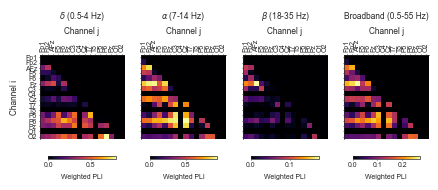

In [12]:
# Get all frequency bands
epoch_name = 'emergence'
frequency_bands = pli.conn_wpli_favg[epoch_name].keys()

ch_names = pli.select_channel_names

greek_band_names = {
    'delta': r'$\delta$',
    'theta': r'$\theta$',
    'alpha': r'$\alpha$',
    'beta': r'$\beta$',
    'gamma': r'$\gamma$'
}

set_custom_style()
plot_width = 100
plot_height = 150

num_bands = len(frequency_bands)  # Calculate the number of subplots
# width_ratios = [1]*num_bands
# width_ratios.append(0.1)
# fig, axes = plt.subplots(1, num_bands+1, figsize=(plot_width*num_bands/72, plot_height/72), width_ratios=width_ratios)

fig, axes = plt.subplots(1, num_bands, figsize=(plot_width*num_bands/72, plot_height/72))

if num_bands == 1:
    axes = [axes]  # Ensure axes is always a list

fontsize = 6

for i, fband in enumerate(frequency_bands):
    entire_epoch_pli = pli.conn_wpli_favg[epoch_name][fband]
    
    im = axes[i].imshow(entire_epoch_pli[:, :, 0], vmin=0,  cmap='inferno', origin='upper')
    
    axes[i].set_xticks(range(16))
    axes[i].set_yticks(range(16))

    axes[i].xaxis.set_ticks_position('top')  # Move x-ticks to the top
    axes[i].set_xticklabels(ch_names, rotation=90)

    if i == 0:
        axes[i].set_yticklabels(ch_names)  # Only set y-tick labels for the first subplot
        axes[i].set_ylabel("Channel i", fontsize=fontsize)
    else:
        axes[i].set_yticklabels([])  # Remove y-tick labels for other subplots

    axes[i].xaxis.set_label_position('top')
    axes[i].set_xlabel("Channel j", fontsize=fontsize)

    axes[i].spines['top'].set_visible(True)
    axes[i].spines['bottom'].set_visible(False)
    
    # Set the title for each subplot to the frequency band
    if fband == 'bb':
        ttl = f'Broadband ({pli.fmin_bb_avg}-{pli.fmax_bb_avg} Hz)'
    else:
        ttl = f'{greek_band_names[fband]} ({pli.frequency_bands_of_interest[fband][0]}-{pli.frequency_bands_of_interest[fband][1]} Hz)'

    axes[i].set_title(ttl, fontsize=fontsize)

    cbar = plt.colorbar(im, ax=axes[i], orientation='horizontal', shrink=0.8, pad=0.1)
    cbar.set_label('Weighted PLI')  # Optional: add a label for the colorbar

# # Add a colorbar
# cbar = plt.colorbar(im, cax=axes[-1], orientation='vertical', shrink=0.6)
# cbar.set_label('wPLI', fontsize=5)
# cbar.outline.set_visible(False)
# cbar.ax.tick_params(labelsize=5)

plt.subplots_adjust(left=0.2,  # Adjust the left margin
                    right=0.9,  # Adjust the right margin
                    bottom=0.1,  # Adjust the bottom margin
                    top=0.9)  # Adjust the top margin

# Save plot
base_results_filename = base_results_dir / f'CA-{participant_id:02}'

filename = f'{base_results_filename}_{epoch_name}_wPLI_favg_entire_epoch.pdf'
file_path = os.path.join(base_results_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

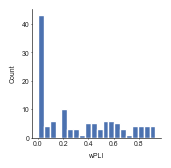

In [13]:
# Plot the histogram of the phase lag indices across all channels pairs to check bimodality
epoch_name ='emergence'
frequency_band = 'alpha'
entire_epoch_pli = pli.conn_wpli_favg[epoch_name][frequency_band]

def bottom_left_off_diagonal(array):
    """Extracts off-diagonal elements from the bottom-left rectangle of a matrix."""

    rows, cols = array.shape
    result = []

    for i in range(1, rows):
        for j in range(0, i):
            result.append(array[i, j])
    return np.array(result)

set_custom_style()
plot_width = 120
plot_height = 120

fig, ax = plt.subplots(1, 1, figsize=(plot_width/72, plot_height/72))
all_plis = bottom_left_off_diagonal(entire_epoch_pli[:, :, 0])
ax.hist(all_plis, bins=20)
ax.set_xlabel('wPLI')
ax.set_ylabel('Count')

plt.show()

##### Plot the wPLI matrix for overlapping windows during a given epoch, such as emergence 

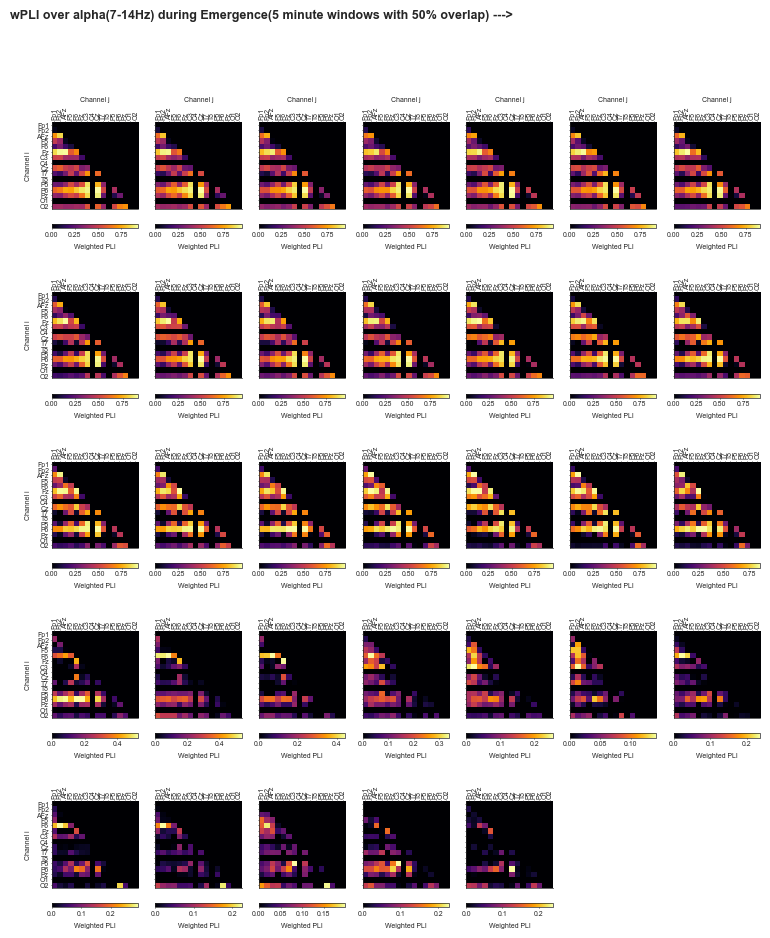

In [14]:
epoch_name = 'emergence'
fband = 'alpha'

ch_names = pli.select_channel_names
curr_pli_win = pli.conn_wpli_win_favg[epoch_name][fband]
num_win = curr_pli_win.shape[2]

num_cols = 7
num_rows = num_win//num_cols + 1

set_custom_style()
plot_width = 600
plot_height = num_rows * 150

fig, axs = plt.subplots(num_rows, num_cols, figsize=(plot_width/72, plot_height/72))

fig.suptitle(f'wPLI over {fband}({pli.frequency_bands_of_interest[fband][0]}-{pli.frequency_bands_of_interest[fband][1]}Hz) during {epoch_name.capitalize()}({int(pli.window_size/60)} minute windows with {int(pli.overlap_ratio*100)}% overlap) --->', x=0.05, ha='left', fontsize=9, fontweight='bold')

for win in range(num_win):

    r = win // num_cols
    c = win % num_cols       
    ax = axs[r, c]

    cax = ax.imshow(curr_pli_win[:, :, win], vmin=0, cmap='inferno', origin='upper') # , vmax=1
    ax.set_xticks(range(16))
    ax.set_yticks(range(16))
    ax.set_yticklabels(ch_names) 
    if c == 0:
        ax.set_ylabel("Channel i")
    # else:
    #     ax.set_yticklabels([])

    ax.xaxis.set_ticks_position('top')  # Move x-ticks to the top
    ax.xaxis.set_label_position('top')
    ax.set_xticklabels(ch_names, rotation=90)
    if r == 0: 
        ax.set_xlabel("Channel j")

    if c != 0:
        ax.set_yticklabels([])

    cbar = plt.colorbar(cax, ax=ax, orientation='horizontal', shrink=1, pad=0.1)
    cbar.set_label('Weighted PLI')  # Optional: add a label for the colorbar

for win in range(num_win, num_rows*num_cols): 
    axs[win // num_cols, win % num_cols].set_visible(False)

plt.subplots_adjust(wspace=0.2, hspace=0.1, left=0.1, right=0.95, bottom=0.1, top=0.9) 

# Save plot
base_results_filename = base_results_dir / f'CA-{participant_id:02}'

if fband == 'bb':
    band_name = f'Broadband ({pli.fmin_bb_avg}-{pli.fmax_bb_avg}Hz)'
else:
    band_name = f'{fband} ({pli.frequency_bands_of_interest[fband][0]}-{pli.frequency_bands_of_interest[fband][1]}Hz)'

filename = f'{base_results_filename}_{epoch_name}_wPLI_favg_fband_'+band_name+ f'_overlap_windows_len_{int(pli.window_size/60)}min_overlap_{int(pli.overlap_ratio)*100}percent.pdf'
file_path = os.path.join(base_results_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()


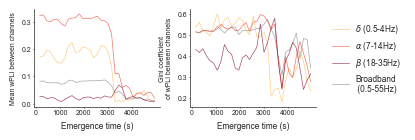

In [15]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = array.flatten()
    if np.amin(array) < 0:
        array -= np.amin(array)
    array = array + 1e-16
    array = np.sort(array)
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]
    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))

epoch_name = 'emergence'

# Define a color map for the frequency bands
frequency_bands = list(pli.conn_wpli_win_favg[epoch_name].keys())

# Create a sequential colormap, 'viridis' for example, excluding the broadband
sequential_cmap = plt.cm.YlOrRd(np.linspace(0.35, 1, len(frequency_bands) - 1))

# Assign colors to frequency bands, keeping 'bb' as gray
color_map = {band: sequential_cmap[i] for i, band in enumerate(frequency_bands[:-1])}
color_map['bb'] = 'gray'


plot_width = 300
plot_height = 100

set_custom_style() 
fig, axs = plt.subplots(1, 3, figsize=(plot_width / 72, plot_height / 72), gridspec_kw={'width_ratios': [3, 3, 1]})
fontsize = 6

for fband in frequency_bands:
    curr_pli_win = pli.conn_wpli_win_favg[epoch_name][fband]
    num_win = curr_pli_win.shape[2]

    network_connectedness = np.full((num_win,), np.nan)
    network_connect_std = np.full((num_win,), np.nan)
    gini_coeff = np.full((num_win,), np.nan)

    for win in range(num_win):
        pli_values = bottom_left_off_diagonal(curr_pli_win[:, :, win])
        network_connectedness[win] = np.mean(pli_values)
        network_connect_std[win] = np.std(pli_values)
        gini_coeff[win] = gini(pli_values)
    
    win_centers = pli.win_centers[epoch_name]
    
    color = color_map[fband]
    zorder = 0 if fband == 'bb' else 1
    
    if fband =='bb':
        label = f'{'Broadband'}\n ({pli.fmin_bb_avg}-{pli.fmax_bb_avg}Hz)'
    else:    
        label = f'{greek_band_names[fband]} ({pli.frequency_bands_of_interest[fband][0]}-{pli.frequency_bands_of_interest[fband][1]}Hz)'
    
    axs[0].plot(win_centers, network_connectedness, linewidth=0.5, color=color, zorder=zorder, label=label, alpha=0.7)
    axs[1].plot(win_centers, gini_coeff, linewidth=0.5, color=color, zorder=zorder, label=label, alpha=0.7)

axs[0].set_xticks(np.arange(0, max(win_centers), 1000))
axs[0].set_xlabel(f'{epoch_name.capitalize()} time (s)', fontsize=fontsize)
axs[0].set_ylabel('Mean wPLI between channels')

axs[1].set_xticks(np.arange(0, max(win_centers), 1000))
axs[1].set_xlabel(f'{epoch_name.capitalize()} time (s)', fontsize=fontsize)
axs[1].set_ylabel('Gini coefficient\nof wPLI between channels')

# Remove the third subplot axes for the legend
axs[2].axis('off')

# Create the legend in the third subplot
legend_lines, legend_labels = axs[1].get_legend_handles_labels()
axs[2].legend(legend_lines, legend_labels, loc='center', fontsize=fontsize)

plt.subplots_adjust(wspace=0.3, hspace=0.1, left=0.1, right=0.95, bottom=0.2, top=0.9)

# Save plot
base_results_filename = base_results_dir / f'CA-{participant_id:02}'
filename = f'{base_results_filename}_{epoch_name}_network_connectedness_wPLI_favg_across_overlap_windows.pdf'
file_path = os.path.join(base_results_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

#### Anatomical average PLI
Calculate the anatomical group-level connectivity (e.g., debiased weighted phase lag index) by averaging the connectivity across all pairs of channels, where one channel belongs to one anatomical region and the other channel belongs to a different anatomical region

In [16]:
pli.calculate_pli_anatomical_average()

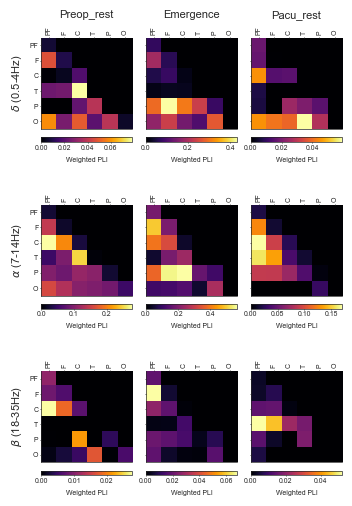

In [18]:
# Extract frequency bands from the dictionary keys
# frequency_bands = list(pli.conn_wpli_favg_anat['preop_rest'].keys())
frequency_bands = ['delta', 'alpha', 'beta']

# Define the epochs
# epochs = ['preop_rest', 'loc', 'maintenance', 'pre_drug_infusion', 'emergence', 'pacu_rest']
epochs = list(pli.conn_wpli_favg_anat.keys())  
num_regions = len(pli.region_names)
region_acr = {
    'frontal': 'F',
    'prefrontal': 'PF',
    'central': 'C',
    'temporal': 'T',
    'occipital': 'O',
    'parietal': 'P'
}

# Create a figure with subplots for each frequency band and each epoch
plot_width = len(epochs)*85
plot_height = 150 * len(frequency_bands)  # Adjust height based on number of frequency bands

set_custom_style() 
fig, axs = plt.subplots(len(frequency_bands), len(epochs), figsize=(plot_width/72, plot_height/72), squeeze=False)

# Loop through each frequency band and each epoch to plot the PLI heatmap
for row, fband in enumerate(frequency_bands):
    for col, epoch in enumerate(epochs):
        entire_epoch_pli = pli.conn_wpli_favg_anat[epoch][fband]

        # Plot the PLI heatmap
        cax = axs[row, col].imshow(entire_epoch_pli, vmin=0, cmap='inferno', origin='upper')

        axs[row, col].set_xticks(range(num_regions))
        axs[row, col].set_yticks(range(num_regions))
        axs[row, col].xaxis.set_ticks_position('top')
        axs[row, col].set_xticklabels([region_acr[name] for name in pli.region_names], rotation=90)
        axs[row, col].set_yticklabels([region_acr[name] for name in pli.region_names])
        if row == 0:
            axs[row, col].set_title(f"{epoch.capitalize()}", fontsize=8, fontweight='regular', loc='center', ha='center')

        # Add a colorbar for each subplot
        cbar = plt.colorbar(cax, ax=axs[row, col], orientation='horizontal', shrink=1, pad=0.05)
        cbar.set_label('Weighted PLI')  # Optional: add a label for the colorbar

        if col != 0:
            axs[row, col].set_yticklabels([])  # Hide y-tick labels for all but the first column

        # if row != 0:
            # axs[row, col].set_xticklabels([])  # Hide x-tick labels for all but the top row

        if col == 0:
            if fband =='bb':
                yl = f'{'Broadband'}\n ({pli.fmin_bb_avg}-{pli.fmax_bb_avg}Hz)'
            else:    
                yl = f'{greek_band_names[fband]} ({pli.frequency_bands_of_interest[fband][0]}-{pli.frequency_bands_of_interest[fband][1]}Hz)'
            
            axs[row, col].set_ylabel(yl, rotation=90, fontsize=8)

# Adjust layout for better spacing
plt.subplots_adjust(wspace=0.15, hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

# Save plot
base_results_filename = base_results_dir / f'CA-{participant_id:02}'
filename = f'{base_results_filename}_inter_region_wPLI_favg_all_epochs.pdf'
file_path = os.path.join(base_results_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

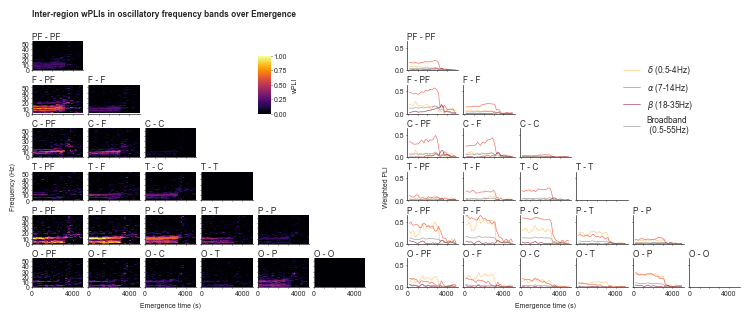

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

frequency_bands = list(pli.conn_wpli_win_favg[epoch_name].keys())

# Create a sequential colormap, 'viridis' for example, excluding the broadband
sequential_cmap = plt.cm.YlOrRd(np.linspace(0.35, 1, len(frequency_bands) - 1))

# Assign colors to frequency bands, keeping 'bb' as gray
color_map = {band: sequential_cmap[i] for i, band in enumerate(frequency_bands[:-1])}
color_map['bb'] = 'gray'

# color_map = {
#     'delta': 'blue',
#     'theta': 'orange',
#     'alpha': 'green',
#     'beta': 'red',
#     'bb': 'gray'
# }

epoch_name = 'emergence'
region_names = pli.region_names
num_regions = len(region_names)
region_acr = {
    'frontal': 'F',
    'prefrontal': 'PF',
    'central': 'C',
    'temporal': 'T',
    'occipital': 'O',
    'parietal': 'P'
}

set_custom_style()
plot_width = 600
plot_height = 230
fontsize=6

set_custom_style() 
fig = plt.figure(figsize=(plot_width/72, plot_height/72))
fig.suptitle(f'Inter-region wPLIs in oscillatory frequency bands over {epoch_name.capitalize()}', x=0.05, ha='left', fontsize=6, fontweight='bold')


# Temporal variation of the anatomically averaged PLIs
win_centers = pli.win_centers[epoch_name]

# Calculate the pairs of regions (below the diagonal)
pairs = [(i, j) for i in range(num_regions) for j in range(i+1)]

# Heatmaps of wPLI calculated for overlapping windows, with no frequency averaging 
gs = fig.add_gridspec(num_regions, num_regions, left=0.05, right=0.45, wspace=0.1, hspace=0.5)
pli_win = pli.conn_wpli_win_anat[epoch_name]
for r1, r2 in pairs:
    ax_sub = fig.add_subplot(gs[r1, r2])

    im = ax_sub.pcolormesh(
        np.array(win_centers), 
        np.arange(pli.fmin, pli.fmax+0.01, 0.1),
        gaussian_filter(pli_win[r1, r2, :, :], sigma=0), vmin=0, vmax=1, cmap='inferno'
    )
    ax_sub.set_title(f'{region_acr[region_names[r1]]} - {region_acr[region_names[r2]]}', loc='left', fontsize=fontsize, pad=0.2)

    ax_sub.set_xticks(np.arange(0, max(win_centers), 1000))
    if r1 <= 4:
        ax_sub.set_xticklabels([])
    else:
        xticklabels_old = ax_sub.get_xticklabels()
        xticklabels = np.full(len(xticklabels_old), '', dtype=object)
        xticklabels[0] = xticklabels_old[0].get_text()
        xticklabels[-1] = xticklabels_old[-1].get_text()
        ax_sub.set_xticklabels(xticklabels)
        
    ax_sub.set_yticks(np.arange(0, 55, 10))

    if r2 != 0:
        ax_sub.set_yticklabels([])

    if (r1 == 3) & (r2 == 0):
        ax_sub.set_ylabel('Frequency (Hz)')

    if (r1 == 5) & (r2 == 2):
        ax_sub.set_xlabel(epoch_name.capitalize()+' time (s)')

# # Add a colorbar
cax = fig.add_subplot(gs[1, 4])
cbar = plt.colorbar(im, cax=cax, orientation='vertical', shrink=0.6)
old_pos = cax.get_position()
new_pos = [old_pos.x0, old_pos.y0, old_pos.width*0.25, old_pos.height*2]
cax.set_position(new_pos)
cbar.set_label('wPLI', fontsize=5)
cbar.outline.set_visible(False)
cbar.ax.tick_params(labelsize=5)


# wPLI calculated for overlapping windows and averaged in specific frequency bands
gs_favg = fig.add_gridspec(num_regions, num_regions, left=0.50, right=0.90, wspace=0.1, hspace=0.5)
for r1, r2 in pairs:
    ax_sub = fig.add_subplot(gs_favg[r1, r2])
    
    for fband in frequency_bands:
        pli_win_favg = pli.conn_wpli_win_favg_anat[epoch_name][fband]
        if fband =='bb':
            label = f'{'Broadband'}\n ({pli.fmin_bb_avg}-{pli.fmax_bb_avg}Hz)'
        else:    
            label = f'{greek_band_names[fband]} ({pli.frequency_bands_of_interest[fband][0]}-{pli.frequency_bands_of_interest[fband][1]}Hz)'
        
        ax_sub.plot(win_centers, pli_win_favg[r1, r2], linewidth=0.5, label=label, color=color_map[fband], alpha=0.7)
    
    ax_sub.set_ylim([0, np.max([pli.conn_wpli_win_favg_anat[epoch_name][fb][:] for fb in frequency_bands])])

    ax_sub.set_title(f'{region_acr[region_names[r1]]} - {region_acr[region_names[r2]]}', loc='left', fontsize=fontsize, pad=0.2)

    ax_sub.set_xticks(np.arange(0, max(win_centers), 1000))
    if r1 <= 4:
        ax_sub.set_xticklabels([])
    else:
        xticklabels_old = ax_sub.get_xticklabels()
        xticklabels = np.full(len(xticklabels_old), '', dtype=object)
        xticklabels[0] = xticklabels_old[0].get_text()
        xticklabels[-1] = xticklabels_old[-1].get_text()
        ax_sub.set_xticklabels(xticklabels)

    if r2 != 0:
        ax_sub.set_yticklabels([])

    if (r1 == 3) & (r2 == 0):
        ax_sub.set_ylabel('Weighted PLI')

    if (r1 == 5) & (r2 == 2):
        ax_sub.set_xlabel(epoch_name.capitalize()+' time (s)')

    ax_sub.spines['top'].set_visible(False)
    ax_sub.spines['right'].set_visible(False)

# Create the legend in the third subplot
ax_legend = fig.add_subplot(gs_favg[1, 4])
legend_lines, legend_labels = ax_sub.get_legend_handles_labels()
ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=fontsize)
ax_legend.spines['bottom'].set_visible(False)
ax_legend.spines['left'].set_visible(False)
ax_legend.set_xticks([])
ax_legend.set_yticks([])
ax_legend.tick_params(bottom=False, left=False)


# Save plot
base_results_filename = base_results_dir / f'CA-{participant_id:02}'

filename = f'{base_results_filename}_{epoch_name}_inter_region_wPLI_heatmaps_and_frequency_band_dynamic.pdf'
file_path = os.path.join(base_results_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

In [ ]:
### Plot the connectivity between a selected region (e.g., frontal cortex) and all other regions over time, overlaying them in the same panel.

import matplotlib
from matplotlib.colors import ListedColormap



epoch_name = 'emergence'
fband = 'alpha'
region_names = pli.region_names
num_regions = len(region_names)

# Select a colormap
colormap = matplotlib.colormaps['tab20b']

# Generate a list of colors from the colormap
colors = [colormap(i / num_regions) for i in range(num_regions)]


plot_width = 300
plot_height = 150

set_custom_style() 
fig, axs = plt.subplots(2, 3, figsize=(plot_width/72, plot_height/72))
axs = axs.flatten()

fig.suptitle(f'Comparison of inter-region wPLIs in {greek_band_names[fband]} over time during {epoch_name.capitalize()}', x=0.05, ha='left', fontsize=6, fontweight='bold')


win_centers = pli.win_centers[epoch_name]

pli_win_favg = pli.conn_wpli_win_favg_anat[epoch_name][fband]
for selected_region_index in range(num_regions):

    curr_ax = axs[selected_region_index]
    for i in range(len(region_names)):
        # if i != selected_region_index:
        # Plot the connectivity between the selected region and the current region
        curr_pli = pli_win_favg[i, selected_region_index]+pli_win_favg[selected_region_index, i]
        curr_pli = curr_pli/np.max(curr_pli)
        curr_ax.plot(win_centers, curr_pli, linewidth=0.5, alpha=0.7, label=region_acr[region_names[i]], color=colors[i])
    
    curr_ax.set_xticks(np.arange(0, max(win_centers), 1000))

    curr_ax.set_title(region_acr[region_names[selected_region_index]], pad=0.1, loc='left')

    if selected_region_index % 3 == 0:
        curr_ax.set_ylabel('Weighted PLI')

    if selected_region_index == 4:
        curr_ax.set_xlabel(epoch_name.capitalize() + ' time (s)')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5), fontsize='small', title='Regions')

plt.subplots_adjust(wspace=0.3, hspace=0.3, left=0.1, right=0.82, bottom=0.1, top=0.85) 


# # Save plot
base_results_filename = base_results_dir / f'CA-{participant_id:02}'
filename = f'{base_results_filename}_{epoch_name}_comparison_of_interregion_wPLI_in_{fband}_over_time.pdf'
file_path = os.path.join(base_results_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()


In [ ]:
epoch_name = 'emergence'
fband = 'alpha'

num_regions = len(pli.region_names)
curr_pli_win = pli.conn_wpli_win_favg_anat[epoch_name][fband]
num_win = curr_pli_win.shape[2]

num_rows = num_win//10 + 1

set_custom_style()

num_cols = 6
num_rows = num_win//num_cols + 1

plot_width = 500
plot_height = num_rows*150
fig, axs = plt.subplots(num_rows, num_cols, figsize=(plot_width/72, plot_height/72))

fig.suptitle(f'wPLI in {greek_band_names[fband]} over {epoch_name.capitalize()} ({int(pli.window_size/60)} minute windows with {int(pli.overlap_ratio*100)}% overlap) --->', x=0.05, ha='left', fontsize=9, fontweight='bold')

for win in range(num_win):
    r = win // num_cols
    c = win % num_cols
    ax = axs[r, c]

    cax = ax.imshow(curr_pli_win[:, :, win], vmin=0, cmap='inferno', origin='upper') # , vmax=0.42
    ax.set_xticks(range(num_regions))
    ax.set_yticks(range(num_regions))
    ax.set_yticklabels([region_acr[name] for name in pli.region_names]) 
    if c != 0:
        ax.set_yticklabels([])

    ax.xaxis.set_ticks_position('top')  # Move x-ticks to the top
    ax.xaxis.set_label_position('top')
    ax.set_xticklabels([region_acr[name] for name in pli.region_names], rotation=90)
    # if r != 0: 
    #    ax.set_xticklabels([])

    cbar = plt.colorbar(cax, ax=ax, orientation='horizontal', shrink=1, pad=0.05)
    cbar.set_label('Weighted PLI')  # Optional: add a label for the colorbar
       
for win in range(num_win, num_rows*num_cols): 
    axs[win // num_cols, win % num_cols].set_visible(False)

plt.subplots_adjust(wspace=0.15, hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

# Save plot
base_results_filename = base_results_dir / f'CA-{participant_id:02}'

filename = f'{base_results_filename}_{epoch_name}_inter_region_wPLI_matrix_{fband}_over_time.pdf'
file_path = os.path.join(base_results_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

In [ ]:
# The overall network connectedness across time windows during an epoch 
epoch_name = 'emergence'
curr_pli_win = pli.conn_wpli_win_favg_anat[epoch_name]['alpha']
num_win = curr_pli_win.shape[2]


network_connectedness = np.full((num_win,), np.nan)
network_connect_std = np.full((num_win,), np.nan)
for win in range(num_win):
    pli_values = bottom_left_off_diagonal(curr_pli_win[:, :, win])
    network_connectedness[win] = np.mean(pli_values)
    network_connect_std[win] = np.std(pli_values)


win_centers = pli.win_centers[epoch_name]

plot_width = 250
plot_height = 100
fig, axs = plt.subplots(1, 2, figsize=(plot_width/72, plot_height/72))
fontsize=6

axs[0].plot(win_centers, network_connectedness, linewidth=0.5, color='k')
axs[0].set_xticks(np.arange(0, max(win_centers), 1000))
axs[0].set_xlabel(f'{epoch_name.capitalize()} time (s)', fontsize=fontsize)
axs[0].set_ylabel('Average network connectedness')

axs[1].plot(win_centers, network_connect_std, linewidth=0.5, color='k')
axs[1].set_xticks(np.arange(0, max(win_centers), 1000))
axs[1].set_xlabel(f'{epoch_name.capitalize()} time (s)', fontsize=fontsize)
axs[1].set_ylabel('Standard deviation\nof network connectedness')

plt.subplots_adjust(wspace=0.3, hspace=0.1, left=0.1, right=0.95, bottom=0.2, top=0.9) 


# Save plot
base_results_filename = base_results_dir / f'CA-{participant_id:02}'

filename = f'{base_results_filename}_{epoch_name}_network_connectedness_region_wPLI_favg_across_overlap_windows.pdf'
file_path = os.path.join(base_results_dir, filename)
# plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

In [ ]:
epoch_name = 'emergence'
region_names = [name.capitalize() for name in pli.region_names]
num_regions = len(region_names)

set_custom_style()
plot_width = 300
plot_height = 200

fig, axs = plt.subplots(2, 3, figsize=(plot_width/72, plot_height/72))
axs = axs.flatten()

fig.suptitle(f"Summation of each region's connectivity with other regions over {epoch_name.capitalize()}", x=0.05, ha='left', fontsize=6, fontweight='bold')


win_centers = pli.win_centers[epoch_name]
num_win = len(win_centers)

pli_win_favg = pli.conn_wpli_win_favg_anat[epoch_name]['alpha']
for selected_region_index in range(num_regions):
    curr_ax = axs[selected_region_index]

    region_mean_connectedness = np.full((num_win,), np.nan)
    region_std_connectedness = np.full((num_win,), np.nan)
    for win in range(num_win):
        pli_values = np.concatenate((pli_win_favg[selected_region_index, :selected_region_index, win], pli_win_favg[(selected_region_index+1):, selected_region_index, win]))
        pli_values = pli_values[pli_values > 0]
        region_mean_connectedness[win] = np.mean(pli_values)
        region_std_connectedness[win] = np.std(pli_values)

    curr_ax.plot(win_centers, region_mean_connectedness, linewidth=0.5, alpha=0.8, color='k', label=region_names[i])
    
    curr_ax.set_xticks(np.arange(0, max(win_centers), 1000))

    curr_ax.set_title(region_names[selected_region_index], pad=0.1)

    if selected_region_index % 3 == 0:
        curr_ax.set_ylabel('Weighted PLI')

    if selected_region_index == 4:
        curr_ax.set_xlabel(epoch_name.capitalize() + ' time (s)')

plt.subplots_adjust(wspace=0.3, hspace=0.5, left=0.1, right=0.82, bottom=0.1, top=0.85) 


# # Save plot
# base_results_filename = base_results_dir / f'CA-{participant_id:02}'
# filename = f'{base_results_filename}_{epoch_name}_region_{region_names[selected_region_index]}_connectivity_over_time.pdf'
# file_path = os.path.join(base_results_dir, filename)
# plt.savefig(file_path, format='pdf', dpi=300)

plt.show()